In [1]:
# %load gen_response_data.py
#!/usr/bin/env python
# ==================================
# File Name: gen_response_data.py
# Author: En-Kun Li, Han Wang
# Mail: lienk@mail.sysu.edu.cn, wanghan657@mail2.sysu.edu.cn
# Created Time: 2023-08-31 09:40:34
# ==================================

import time
import numpy as np
import matplotlib.pyplot as plt

from gwspace.Waveform import waveforms
from gwspace.response import get_y_slr_td, trans_y_slr_fd, get_XYZ_td, get_XYZ_fd, get_AET_fd, tdi_XYZ2AET
from gwspace.Orbit import detectors
from gwspace.Constants import DAY, YRSID_SI


def generate_td_data(pars, s_type='gcb', det='TQ', Tobs=YRSID_SI, dt=1, show_y_slr=False):
    print("This is TD response generation code")

    # tf = np.arange(0,Tobs, delta_T)
    # be careful, the arange method will lose the largest value
    tf = np.linspace(0, Tobs, int(Tobs/dt))

    print(f"Testing of {s_type} waveform")
    wf = waveforms[s_type](**pars)
    st = time.time()
    y_slr = get_y_slr_td(wf, tf, det)
    ed = time.time()
    print(f"Time cost is {ed-st} s for {tf.shape[0]} points")

    if show_y_slr:
        tags = [(1, 2), (2, 1), (2, 3), (3, 2), (3, 1), (1, 3)]
        for i, tag in enumerate(tags):
            plt.figure()
            for j in range(4):
                plt.subplot(4, 1, j+1)
                plt.plot(tf, y_slr[tag][f"{j}L"])
                plt.title(f"y_{tag} [{j}]L")

    st = time.time()
    X, Y, Z = get_XYZ_td(y_slr)
    A, E, T = tdi_XYZ2AET(X, Y, Z)
    ed = time.time()
    print("Time cost for cal XYZ and AET with y_slr is ", ed-st)
    # np.save(det+s_type+"_X_td.npy", np.array([tf, X]))
    return (tf,X,Y,Z,A,E,T)

In [13]:
f0 = [0.00622028]
fd = [7.48528554e-16]
beta = [-0.082205]  # ecliptic latitude [rad]
Lambda = [2.10225]  # ecliptic longitude [rad]

Amp = [6.37823e-23]
iota = [0.645772]
psi = [2.91617795]
phi0 = [3.1716561]
Tobs = 62914560.0
Cadence = 15.0

In [37]:
GCBpars = {
    "mass1": 0.5,
    "mass2": 0.275,
    "DL": 0.004716164547019551,
    "phi0": 3.1716561,
    "f0": 0.00622028,
    "fdot": 7.48528554e-16,
    "fddot": 0.0,
    "psi": 0.2,
    "iota": 0.645772,
    "Lambda": 2.10225,
    "Beta": -0.082205,
    "T_obs": YRSID_SI,
}

In [38]:
gcbwf = waveforms["gcb"](**GCBpars, dt=15)

In [39]:
gcbwf.amp/Amp[0]

1.0000000000000002

In [40]:
tf,X,Y,Z,A,E,T = generate_td_data(GCBpars, dt=15)

This is TD response generation code
Testing of gcb waveform
Time cost is 2.640327215194702 s for 2103876 points
Time cost for cal XYZ and AET with y_slr is  0.05746054649353027


In [49]:
dt = 15
fs = 1/dt

X_fd = np.fft.rfft(X)/len(X)*2

xf = np.linspace(0,fs/2,len(X_fd))

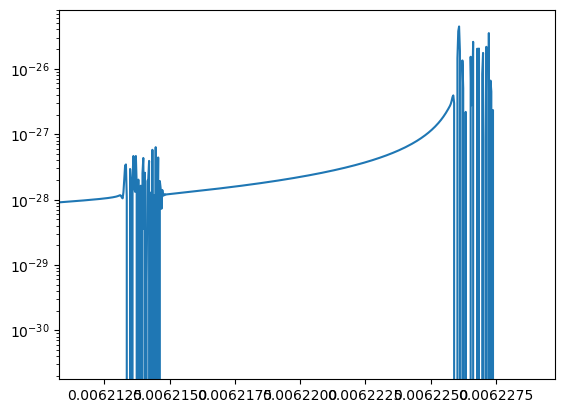

In [50]:
#plt.plot(tf,X)
plt.plot(xf, X_fd)

f0 = GCBpars["f0"]

#plt.axvline(f0, color="red", ls="--")

df = xf[1]-xf[0]
plt.xlim(f0-300*df, f0+300*df)
#plt.xlim(0.025,0.030)
#plt.xscale("log")
plt.yscale("log")

In [18]:
from gwspace.Orbit import TianQinOrbit
from gwspace.Orbit import get_pos

In [20]:
st = time.time()
Tobs = YRSID_SI
delta_T = 10
tf = np.arange(0, Tobs, delta_T)

TQOrbit = TianQinOrbit(tf)
ed = time.time()
print(f"Time cost for initial position: {ed-st} s")

p1, p2, p3 = TQOrbit.orbits

Time cost for initial position: 0.6421749591827393 s


In [21]:
p1

array([[-1.27729940e+02, -1.27728976e+02, -1.27728013e+02, ...,
        -1.28031897e+02, -1.28030994e+02, -1.28030091e+02],
       [-4.84202950e+02, -4.84203192e+02, -4.84203434e+02, ...,
        -4.84410022e+02, -4.84410292e+02, -4.84410563e+02],
       [ 0.00000000e+00, -6.63637412e-05, -1.32727480e-04, ...,
        -3.31130698e-01, -3.31124802e-01, -3.31118892e-01]])

In [22]:
x,y,z,l = get_pos(tf)

In [23]:
x

array([[-127.72993986, -127.72897644, -127.72801304, ..., -127.7543444 ,
        -127.75340567, -127.75246696],
       [-128.14903926, -128.14812957, -128.14721988, ..., -128.24845257,
        -128.24752682, -128.24660106],
       [-128.17306611, -128.17205724, -128.17104836, ..., -128.05782604,
        -128.05680854, -128.05579105]])

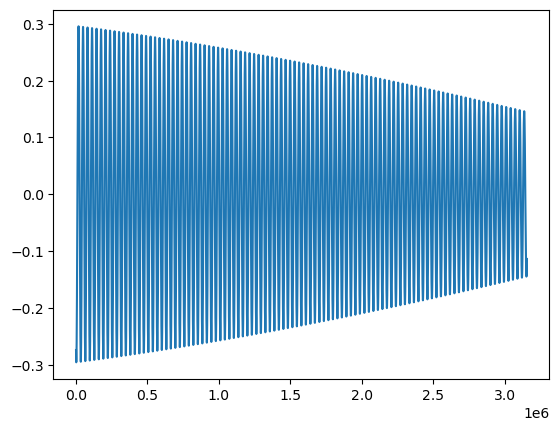

In [27]:
plt.plot(y[1] - p1[1])

In [57]:
from gwspace.Waveform import GCBWaveform as gcb
from gwspace.response import trans_y_slr_fd as trans
from gwspace.Orbit import get_pos

In [61]:
def transfer_slr(freq, LT, knl, krr, krs):
    return 0.5 * np.sinc(freq*LT * (1-knl)) * np.exp(-1j*freq*(LT+krr+krs))

def _dot_arr(a,b):
    return a[0]*b[0]+a[1]*b[1]+a[2]*b[2]

def _cal_zeta(u,v,n):
    nu = _dot_arr(n,u)
    nv = _dot_arr(n,v)
    zp = nu**2 - nv**2
    zc = 2*nu*nv
    return zp, zc

def _cal_xi(tf,k,r):
    return tf - _dot_arr(k,r)

def get_yslr(tf, freq, u,v,k, wf, detector="TianQin"):
    xt,yt,zt,LT = get_pos(tf, detector)
    ni = lambda i,j: np.array([xt[j]-xt[i], yt[j]-yt[i], zt[j]-zt[i]])/LT    
    n1 = ni(2,1); n2 = ni(0,2); n3 = ni(1,0)
    kn1 = _dot_arr(k,n1)
    kn2 = _dot_arr(k,n2)
    kn3 = _dot_arr(k,n3)

    kr1 = _dot_arr(k, np.array([xt[0],yt[0],zt[0]]))
    kr2 = _dot_arr(k, np.array([xt[1],yt[1],zt[1]]))
    kr3 = _dot_arr(k, np.array([xt[2],yt[2],zt[2]]))

    zp1,zc1 = _cal_zeta(u,v,n1)
    zp2,zc2 = _cal_zeta(u,v,n2)
    zp3,zc3 = _cal_zeta(u,v,n3)

    sinc12 = np.sinc(freq*LT*(1+kn3))
    sinc23 = np.sinc(freq*LT*(1+kn1))
    sinc31 = np.sinc(freq*LT*(1+kn2))

    sinc21 = np.sinc(freq*LT*(1-kn3))
    sinc32 = np.sinc(freq*LT*(1-kn1))
    sinc13 = np.sinc(freq*LT*(1-kn2))

    exp12 = np.exp(-1j*np.pi*freq*(LT+kr1+kr2))
    exp23 = np.exp(-1j*np.pi*freq*(LT+kr2+kr3))
    exp31 = np.exp(-1j*np.pi*freq*(LT+kr3+kr1))

    fact = -1j*np.pi*freq*LT

    yslr = {}
    for i in range(4):
        ts = tf - i*LT
        hp, hc = wf.get_hphc(ts)
        yslr["%sL"%i] = {
            (1,2): fact*sinc12*exp12*(zp3*hp + zc3*hc),
            (2,1): fact*sinc21*exp12*(zp3*hp + zc3*hc),
            (2,3): fact*sinc23*exp23*(zp1*hp + zc1*hc),
            (3,2): fact*sinc32*exp23*(zp1*hp + zc1*hc),
            (3,1): fact*sinc31*exp31*(zp2*hp + zc2*hc),
            (1,3): fact*sinc13*exp31*(zp2*hp + zc2*hc),
        }
    return yslr

In [62]:
GCBpars = {
    "mass1": 0.5,
    "mass2": 0.275,
    "DL": 0.004716164547019551,
    "phi0": 3.1716561,
    "f0": 0.00622028,
    "fdot": 7.48528554e-16,
    "fddot": 0.0,
    "psi": 0.2,
    "iota": 0.645772,
    "Lambda": 2.10225,
    "Beta": -0.082205,
    "T_obs": YRSID_SI,
}

gcbwf = gcb(**GCBpars)

dt = 15
tf = np.arange(0,YRSID_SI, dt)
det = detectors["TQ"](tf)


In [63]:
u,v,k = gcbwf.vec_u, gcbwf.vec_v, gcbwf.vec_k
hp, hc = gcbwf.get_hphc(tf)
freq = GCBpars["f0"]

yslr = get_yslr(tf, freq, u,v,k, gcbwf, detector="TianQin")

In [65]:
X_td = yslr["0L"][(3,1)]

In [72]:
X_fd = np.fft.rfft(X_td)/X

(array([0.86207128, 0.50678705, 0.        ]),
 array([-0.04161352,  0.07078678,  0.99662307]),
 array([ 0.50507566, -0.85916013,  0.08211245]))

In [88]:
xt,yt,zt,LT = get_pos(tf, "TianQin")

ni = lambda i,j: np.array([xt[j]-xt[i], yt[j]-yt[i], zt[j]-zt[i]])/LT    
n1 = ni(2,1); n2 = ni(0,2); n3 = ni(1,0)
kn1 = _dot_arr(k,n1)
kn2 = _dot_arr(k,n2)
kn3 = _dot_arr(k,n3)

kn1.shape

(2103877,)

In [89]:
xt.shape, n1.shape

((3, 2103877), (3, 2103877))

In [91]:
kr1 = _dot_arr(k, np.array([xt[0],yt[0],zt[0]]))
kr2 = _dot_arr(k, np.array([xt[1],yt[1],zt[1]]))
kr3 = _dot_arr(k, np.array([xt[2],yt[2],zt[2]]))

kr1

array([351.49458332, 351.49561692, 351.49665053, ..., 351.49184611,
       351.49287976, 351.49391341])

In [92]:
zp1,zc1 = _cal_zeta(u,v,n1)
zp2,zc2 = _cal_zeta(u,v,n2)
zp3,zc3 = _cal_zeta(u,v,n3)

zp1

array([-0.99999996, -0.99999987, -0.99999942, ..., -0.63646533,
       -0.6360042 , -0.63554283])

In [93]:
sinc12 = np.sinc(freq*LT*(1+kn3))
sinc23 = np.sinc(freq*LT*(1+kn1))
sinc31 = np.sinc(freq*LT*(1+kn2))
sinc21 = np.sinc(freq*LT*(1-kn3))
sinc32 = np.sinc(freq*LT*(1-kn1))
sinc13 = np.sinc(freq*LT*(1-kn2))

sinc12

array([0.99997878, 0.99997878, 0.99997878, ..., 0.99997879, 0.99997879,
       0.99997879])

In [94]:
exp12 = np.exp(-1j*np.pi*freq*(LT+kr1+kr2))
exp23 = np.exp(-1j*np.pi*freq*(LT+kr2+kr3))
exp31 = np.exp(-1j*np.pi*freq*(LT+kr3+kr1))
fact = -1j*np.pi*freq*LT

exp12

array([0.37865815-0.9255366j , 0.37862076-0.9255519j ,
       0.37858337-0.9255672j , ..., 0.37875522-0.92549689j,
       0.37871783-0.92551219j, 0.37868044-0.92552749j])

In [95]:
fact*sinc12*exp12*zp3*hp

array([-5.45400715e-25-2.23135882e-25j, -4.45725496e-25-1.82335454e-25j,
       -1.96830853e-25-8.05094301e-26j, ...,
        5.88223542e-25+2.40727697e-25j, -8.76145220e-27-3.58516957e-27j,
       -6.02959259e-25-2.46701344e-25j])

In [96]:




yslr = {
    (1,2): fact*sinc12*exp12*(zp3*hp + zc3*hc),
    (2,1): fact*sinc21*exp12*(zp3*hp + zc3*hc),
    (2,3): fact*sinc23*exp23*(zp1*hp + zc1*hc),
    (3,2): fact*sinc32*exp23*(zp1*hp + zc1*hc),
    (3,1): fact*sinc31*exp31*(zp2*hp + zc2*hc),
    (1,3): fact*sinc13*exp31*(zp2*hp + zc2*hc),
}

/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


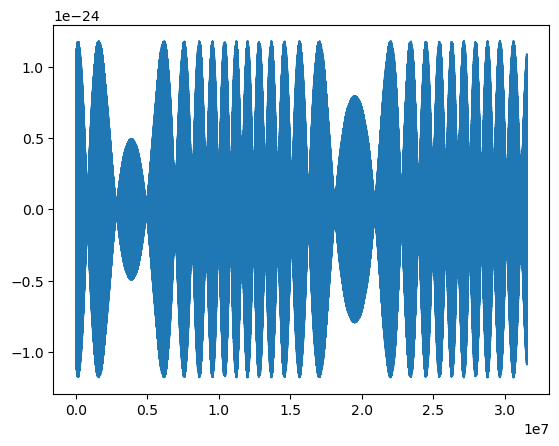

In [97]:
plt.plot(tf, yslr[(1,2)])